# Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D,Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
import os
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Construct Filepath image to dataframe with image classes

In [3]:
bengin_path = r"/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_path = r"/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
normal_path = r"/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases"

img_classes = ["Bengin cases", "Malignant cases", "Normal cases"]
path_list = [bengin_path, malignant_path, normal_path]

img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()

,img_path,label
0,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases
1,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases
2,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases
3,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases
4,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases


# Visualization Image

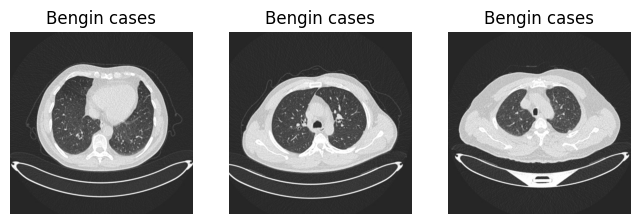

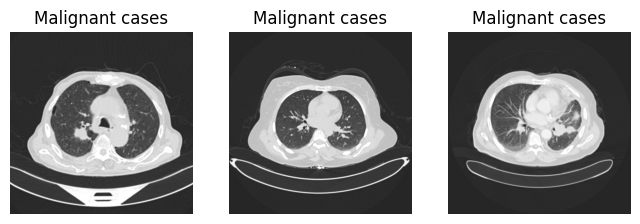

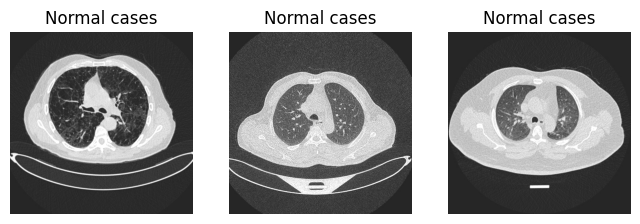

In [4]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (8,8))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

# Exploratory Data Analysis

In [5]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

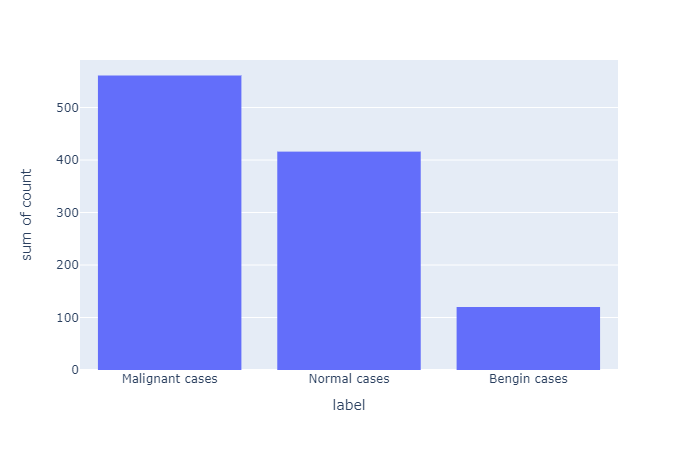

In [6]:
countData = df["label"].value_counts().reset_index()
fig = px.histogram(data_frame = countData, x = "label", y = "count")
fig.show()

## Extract Image Properties (Size, Resolution, Color Distribution)

In [7]:
sizes = []
resolutions = []
color_distributions = []

for img_path in df["img_path"]:
    #load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Get image size
    size = os.path.getsize(img_path)
    sizes.append(size)
    #Extract the resolution of images
    resolution = img.shape[:2]
    resolutions.append(resolution)
    #Extract color distribution
    mean_color_distributions = np.bincount(img.flatten(), minlength = 256)
    color_distributions.append(mean_color_distributions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

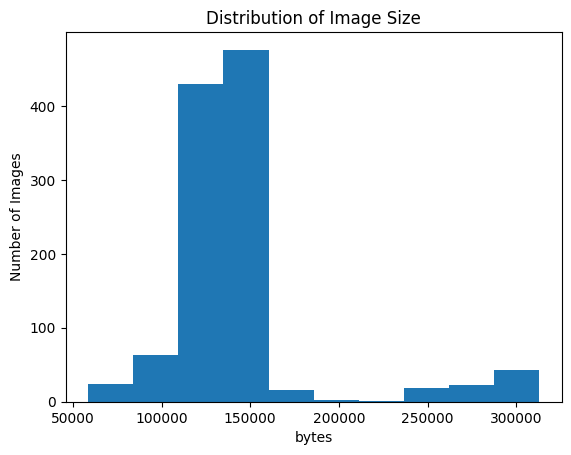

In [8]:
plt.hist(sizes)
plt.title("Distribution of Image Size")
plt.xlabel("bytes")
plt.ylabel("Number of Images")
plt.show()

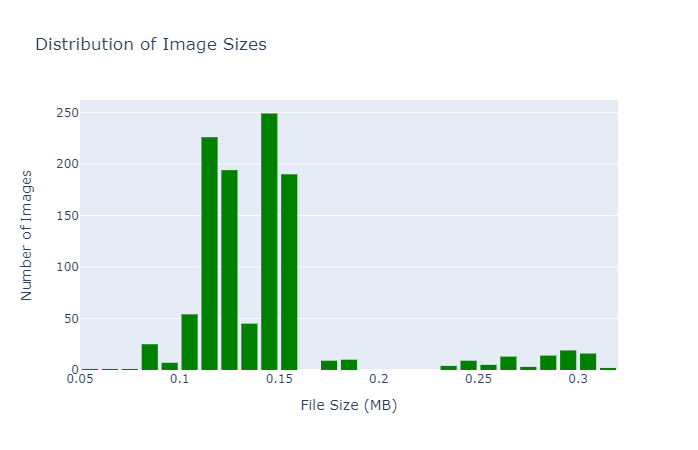

In [9]:
#Sizes in MB
sizes_MB = []
for img_path in df["img_path"]:
    #load image
    img = cv2.imread(img_path)
    #Get image size
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_000_000)
    
fig = px.histogram(x=sizes_MB, nbins = 50, title = "Distribution of Image Sizes")
fig.update_layout(xaxis_title = "File Size (MB)",
                 yaxis_title = "Number of Images",
                 showlegend = False,
                 bargap = 0.1,
                 bargroupgap = 0.1)
fig.update_traces(marker = dict(color = "green"))
fig.show()

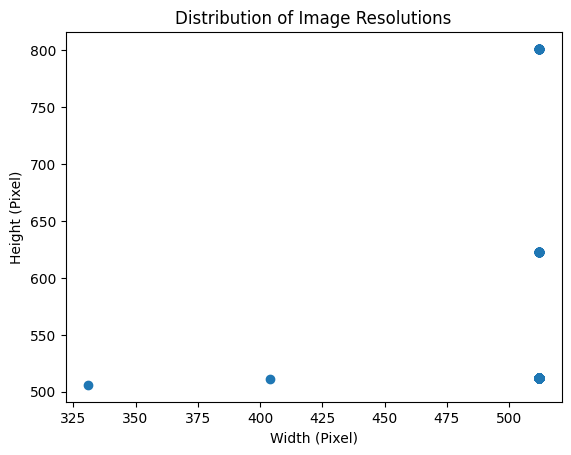

In [10]:
plt.scatter(resolutions[:,0], resolutions[:,1])
plt.title("Distribution of Image Resolutions")
plt.ylabel("Height (Pixel)")
plt.xlabel("Width (Pixel)")
plt.show()

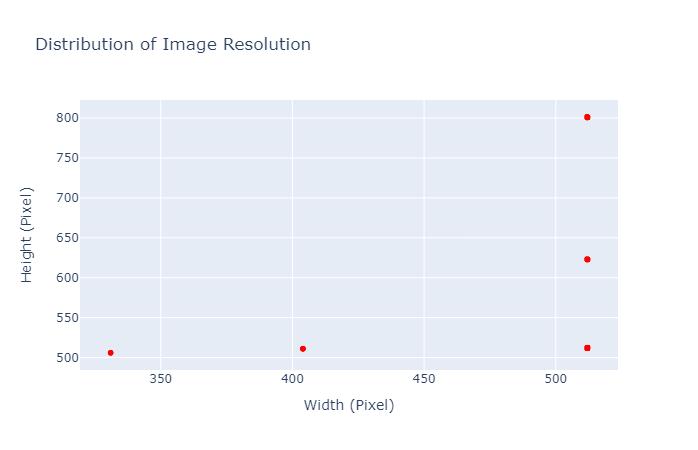

In [11]:
fig = px.scatter(x = resolutions[:,0], y = resolutions[:,1], title = "Distribution of Image Resolution")
fig.update_layout(
    xaxis_title = "Width (Pixel)",
    yaxis_title = "Height (Pixel)",
    showlegend = False,
    hovermode = "closest"
)
fig.update_traces(marker = dict(color="red"))
fig.show()

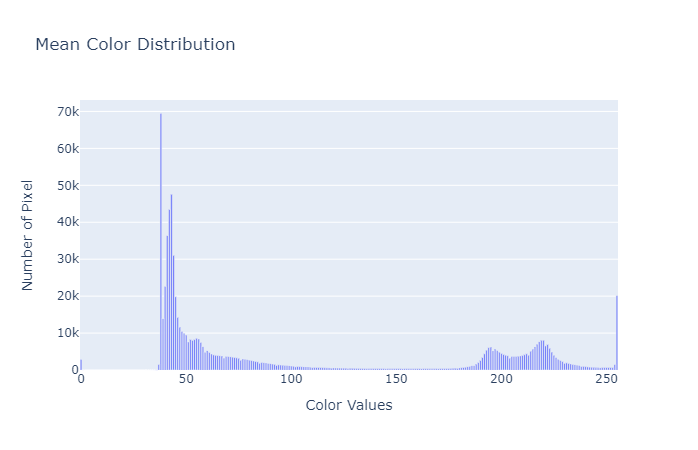

In [12]:
import plotly.graph_objects as go
mean_color_distributions = np.mean(color_distributions, axis = 0)
fig = go.Figure(
    go.Bar(x = np.arange(256), y = mean_color_distributions, name = "Mean Color Distributions"
))
fig.update_layout(
    title = "Mean Color Distribution",
    xaxis_title = "Color Values",
    yaxis_title = "Number of Pixel"
)
fig.show()

# Train Test Split

In [13]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

Train shape = (767, 2)
Test shape = (165, 2)
Validation shape = (165, 2)


# Create Denoise Function using Median Blur

In [14]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

# Image Data Generator

In [15]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                  rotation_range = 30,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.2,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

val_generator = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


In [16]:
classes = list(train_generator.class_indices.keys())
classes

['Bengin cases', 'Malignant cases', 'Normal cases']

In [17]:
#Weight Class
class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Bengin cases : 3.1958333333333333
Malignant cases : 0.6606373815676141
Normal cases : 0.8522222222222222


# Create Custom CNN Model

In [18]:
model1 = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), input_shape = (224, 224, 3), activation = "relu", padding = "same"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),
    
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),
    
    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),
    
    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),
    
    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),
    
    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(4096, activation = "relu"),
    Dropout(0.5),
    Dense(256),
    Dropout(0.25),
    Dense(3, activation = "softmax")
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                        

In [19]:
model1.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"],
)

epochs = 50
history = model1.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 21s 449ms/step - loss: 1.4817 - accuracy: 0.5515 - val_loss: 1.2722 - val_accuracy: 0.3636 - lr: 5.0000e-04
Epoch 2/50
24/24 [==============================] - 12s 497ms/step - loss: 1.5879 - accuracy: 0.5984 - val_loss: 1.8674 - val_accuracy: 0.5273 - lr: 5.0000e-04
Epoch 3/50
24/24 [==============================] - 12s 503ms/step - loss: 1.7531 - accuracy: 0.6010 - val_loss: 7.6077 - val_accuracy: 0.5273 - lr: 5.0000e-04
Epoch 4/50
24/24 [==============================] - 12s 497ms/step - loss: 1.0817 - accuracy: 0.6728 - val_loss: 3.5361 - val_accuracy: 0.3636 - lr: 5.0000e-04
Epoch 5/50
24/24 [==============================] - 12s 494ms/step - loss: 1.1559 - accuracy: 0.6793 - val_loss: 2.5363 - val_accuracy: 0.5273 - lr: 5.0000e-04
Epoch 6/50
24/24 [==============================] - 12s 502ms/step - loss: 0.9928 - accuracy: 0.7210 - val_loss: 4.9237 - val_accuracy: 0.5273 - lr: 1.0000e-04


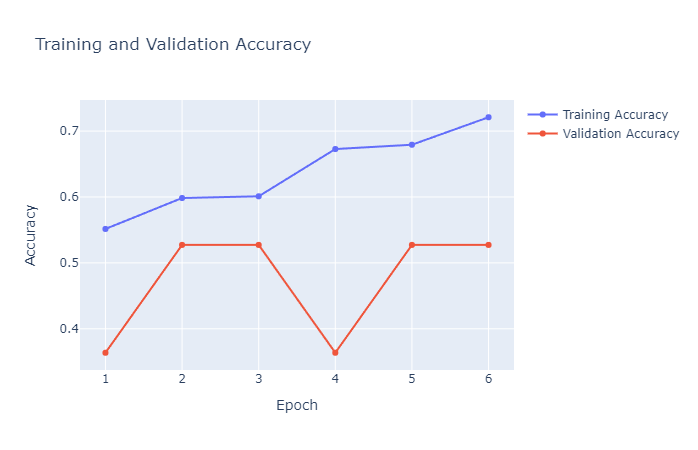

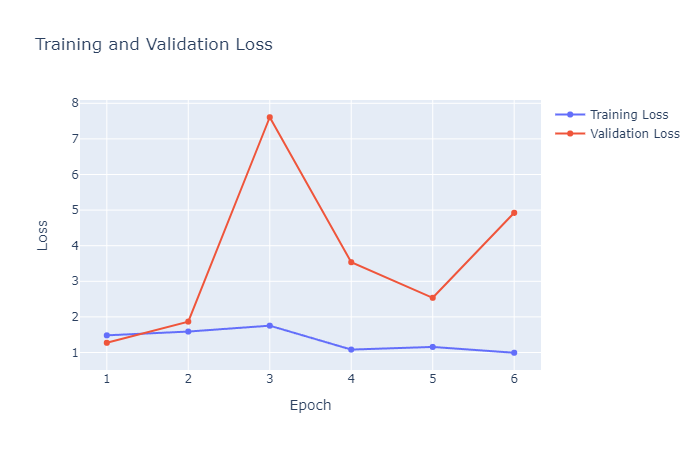

In [20]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["accuracy"], name = "Training Accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_accuracy"], name = "Validation Accuracy"))
    fig1.update_layout(title = "Training and Validation Accuracy", xaxis_title = "Epoch", yaxis_title = "Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["loss"], name = "Training Loss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_loss"], name = "Validation Loss"))
    fig2.update_layout(title = "Training and Validation Loss", xaxis_title = "Epoch", yaxis_title = "Loss")
    fig2.show()

history_plot(epochs, history)

In [21]:
def evaluate_model(model, test_generator):
    #Calculate test loss and accuracy
    results = model.evaluate(test_generator, verbose = 0)
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")

In [22]:
evaluate_model(model1, test_generator)

Test Loss = 1.3393855094909668
Test Accuracy = 0.3393939435482025


In [23]:
model1.save("CNN(Custom).keras")

# Using Pretrained Model InceptionV3

In [24]:
base_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

87910968/87910968 [==============================] - 1s 0us/step


In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
model2 = Sequential()
model2.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation = "relu"))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation = "softmax"))

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              52429824  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 74235683 (283.19 MB)
Trainable params: 52432899 (200.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None

In [27]:
epochs = 50
model2.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])
history = model2.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 21s 570ms/step - loss: 16.8257 - accuracy: 0.5619 - val_loss: 1.7953 - val_accuracy: 0.7879 - lr: 5.0000e-04
Epoch 2/50
24/24 [==============================] - 12s 511ms/step - loss: 5.5748 - accuracy: 0.7040 - val_loss: 2.0176 - val_accuracy: 0.8364 - lr: 5.0000e-04
Epoch 3/50
24/24 [==============================] - 13s 527ms/step - loss: 4.2540 - accuracy: 0.7053 - val_loss: 0.8120 - val_accuracy: 0.8667 - lr: 5.0000e-04
Epoch 4/50
24/24 [==============================] - 12s 517ms/step - loss: 2.6230 - accuracy: 0.7301 - val_loss: 0.6222 - val_accuracy: 0.8242 - lr: 5.0000e-04
Epoch 5/50
24/24 [==============================] - 13s 534ms/step - loss: 1.6996 - accuracy: 0.7484 - val_loss: 0.3016 - val_accuracy: 0.8909 - lr: 5.0000e-04
Epoch 6/50
24/24 [==============================] - 12s 503ms/step - loss: 1.4312 - accuracy: 0.7471 - val_loss: 1.0961 - val_accuracy: 0.5818 - lr: 5.0000e-04
Epoch 7/50
24/24 [=====================

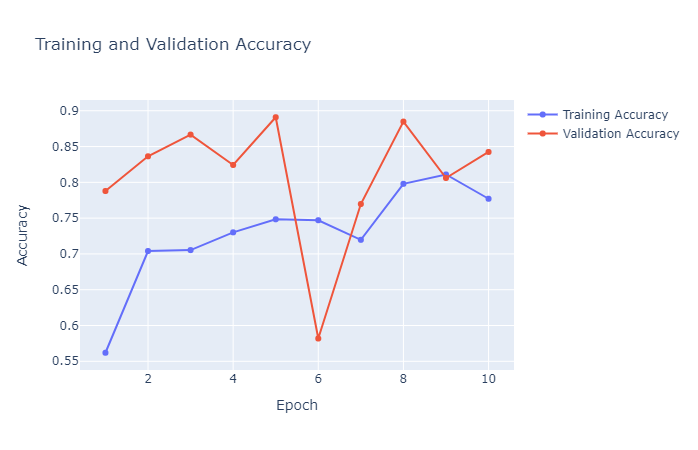

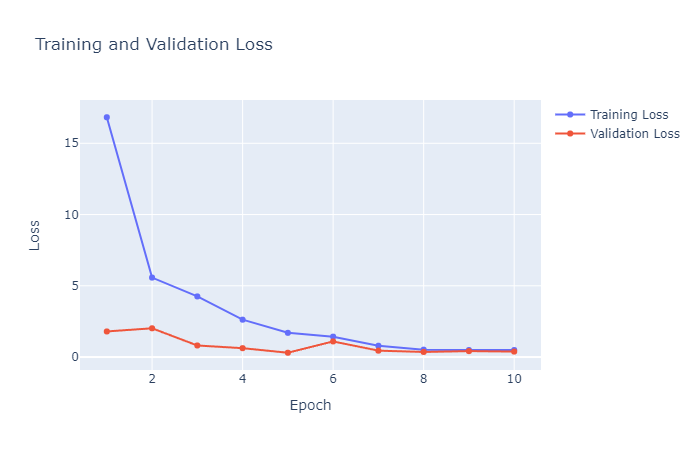

In [28]:
history_plot(epochs, history)

In [29]:
evaluate_model(model2, test_generator)

Test Loss = 0.4013426899909973
Test Accuracy = 0.8666666746139526


# Fine Tuning Pretrained Model : InceptionV3

In [30]:
base_model.trainable = True

for l in base_model.layers[:10]:
    print(l.name, l.trainable)

model2.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

print(model2.summary())

input_1 True
conv2d_6 True
batch_normalization_6 True
activation True
conv2d_7 True
batch_normalization_7 True
activation_1 True
conv2d_8 True
batch_normalization_8 True
activation_2 True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              52429824  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 3075      
                                                                

In [31]:
epochs = 50
history = model2.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 49s 495ms/step - loss: 2.1712 - accuracy: 0.6780 - val_loss: 0.4488 - val_accuracy: 0.8424 - lr: 1.0000e-05
Epoch 2/50
24/24 [==============================] - 13s 526ms/step - loss: 1.0530 - accuracy: 0.6610 - val_loss: 0.5064 - val_accuracy: 0.7818 - lr: 1.0000e-05
Epoch 3/50
24/24 [==============================] - 13s 526ms/step - loss: 0.9397 - accuracy: 0.7053 - val_loss: 0.4138 - val_accuracy: 0.8182 - lr: 1.0000e-05
Epoch 4/50
24/24 [==============================] - 12s 513ms/step - loss: 0.8731 - accuracy: 0.7066 - val_loss: 0.5069 - val_accuracy: 0.7758 - lr: 1.0000e-05
Epoch 5/50
24/24 [==============================] - 13s 520ms/step - loss: 0.7515 - accuracy: 0.7471 - val_loss: 0.6331 - val_accuracy: 0.7636 - lr: 1.0000e-05
Epoch 6/50
24/24 [==============================] - 13s 515ms/step - loss: 0.7815 - accuracy: 0.7210 - val_loss: 0.7241 - val_accuracy: 0.7697 - lr: 2.0000e-06
Epoch 7/50
24/24 [======================

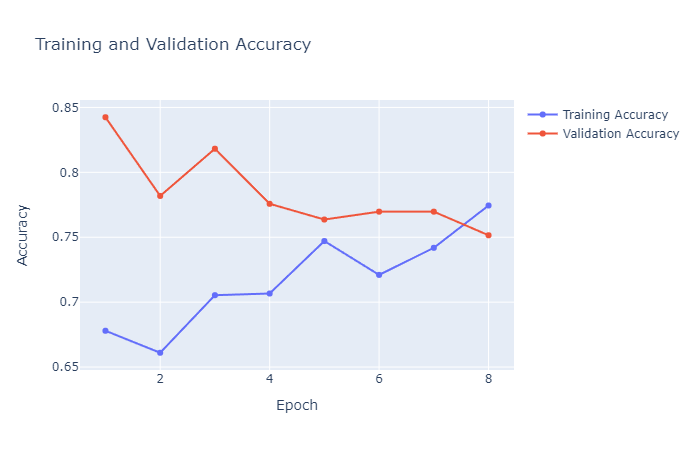

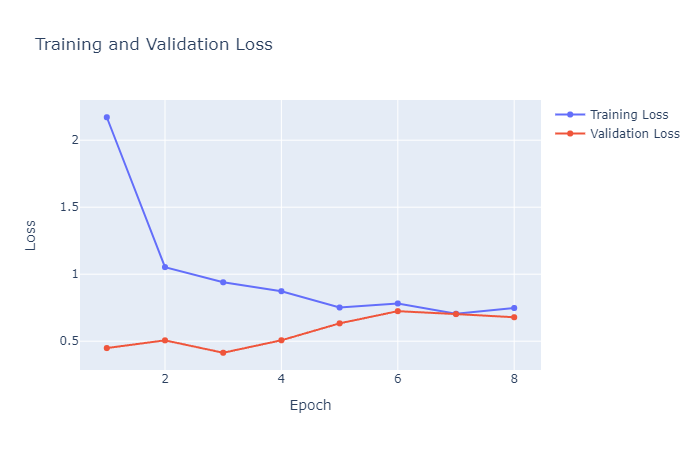

In [32]:
history_plot(epochs, history)

In [33]:
evaluate_model(model2, test_generator)

Test Loss = 0.48617762327194214
Test Accuracy = 0.7878788113594055


In [34]:
model2.save("InceptionV3.keras")

# Pretrained Model VGG-16

In [35]:
base_model_vgg16 = VGG16(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

58889256/58889256 [==============================] - 1s 0us/step


In [36]:
for layer in base_model_vgg16.layers:
    layer.trainable = False

In [37]:
model3 = Sequential()
model3.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(1024, activation = "relu"))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation = "softmax"))

print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              52429824  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 74235683 (283.19 MB)
Trainable params: 74201251 (283.06 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________
None


In [38]:
model3.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

epochs = 50
history = model3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 45s 508ms/step - loss: 6.1154 - accuracy: 0.5515 - val_loss: 304.5797 - val_accuracy: 0.5273 - lr: 5.0000e-04
Epoch 2/50
24/24 [==============================] - 13s 524ms/step - loss: 0.6623 - accuracy: 0.7027 - val_loss: 471.7491 - val_accuracy: 0.5273 - lr: 5.0000e-04
Epoch 3/50
24/24 [==============================] - 13s 531ms/step - loss: 0.5629 - accuracy: 0.7679 - val_loss: 87.7688 - val_accuracy: 0.5273 - lr: 5.0000e-04
Epoch 4/50
24/24 [==============================] - 13s 533ms/step - loss: 0.5705 - accuracy: 0.7849 - val_loss: 87.0342 - val_accuracy: 0.5333 - lr: 5.0000e-04
Epoch 5/50
24/24 [==============================] - 13s 539ms/step - loss: 0.5151 - accuracy: 0.7784 - val_loss: 44.2119 - val_accuracy: 0.5697 - lr: 5.0000e-04
Epoch 6/50
24/24 [==============================] - 13s 548ms/step - loss: 0.4989 - accuracy: 0.7849 - val_loss: 1.3716 - val_accuracy: 0.8545 - lr: 5.0000e-04
Epoch 7/50
24/24 [===============

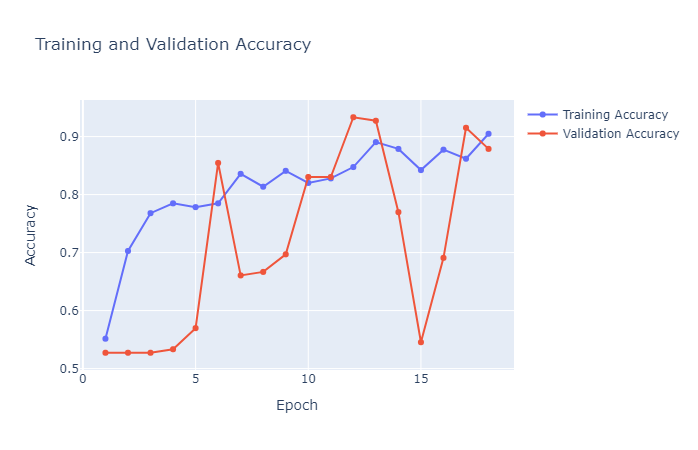

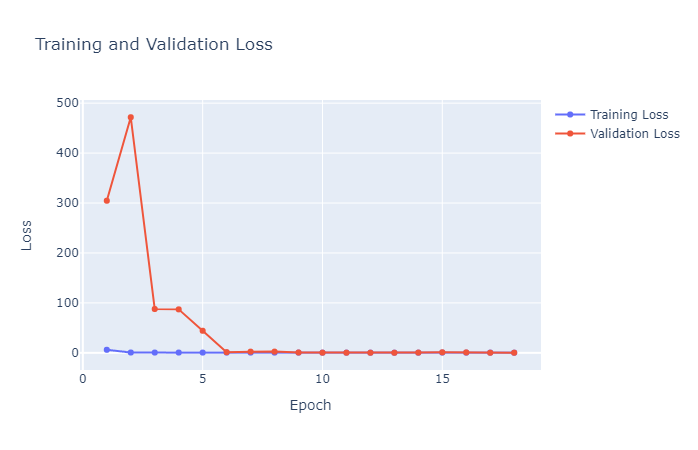

In [39]:
history_plot(epochs, history)

In [40]:
evaluate_model(model3,test_generator)

Test Loss = 0.22609421610832214
Test Accuracy = 0.8787878751754761


# Fine Tuning Model VGG16

In [41]:
base_model_vgg16.trainable = True
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model3.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [42]:
epochs = 50
history = model3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 44s 494ms/step - loss: 0.3458 - accuracy: 0.9022 - val_loss: 0.1548 - val_accuracy: 0.9212 - lr: 1.0000e-05
Epoch 2/50
24/24 [==============================] - 13s 542ms/step - loss: 0.2638 - accuracy: 0.9113 - val_loss: 0.1489 - val_accuracy: 0.9333 - lr: 1.0000e-05
Epoch 3/50
24/24 [==============================] - 13s 537ms/step - loss: 0.2884 - accuracy: 0.9009 - val_loss: 0.1417 - val_accuracy: 0.9394 - lr: 1.0000e-05
Epoch 4/50
24/24 [==============================] - 13s 537ms/step - loss: 0.2407 - accuracy: 0.9231 - val_loss: 0.1345 - val_accuracy: 0.9394 - lr: 1.0000e-05
Epoch 5/50
24/24 [==============================] - 13s 536ms/step - loss: 0.2157 - accuracy: 0.9192 - val_loss: 0.1216 - val_accuracy: 0.9394 - lr: 1.0000e-05
Epoch 6/50
24/24 [==============================] - 13s 529ms/step - loss: 0.2292 - accuracy: 0.9283 - val_loss: 0.1055 - val_accuracy: 0.9515 - lr: 1.0000e-05
Epoch 7/50
24/24 [======================

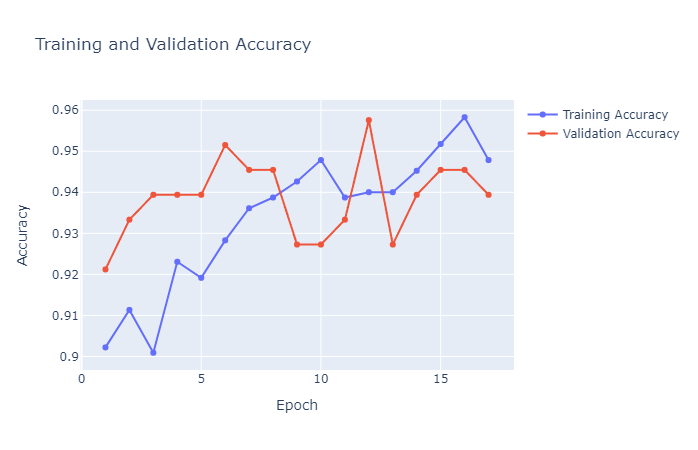

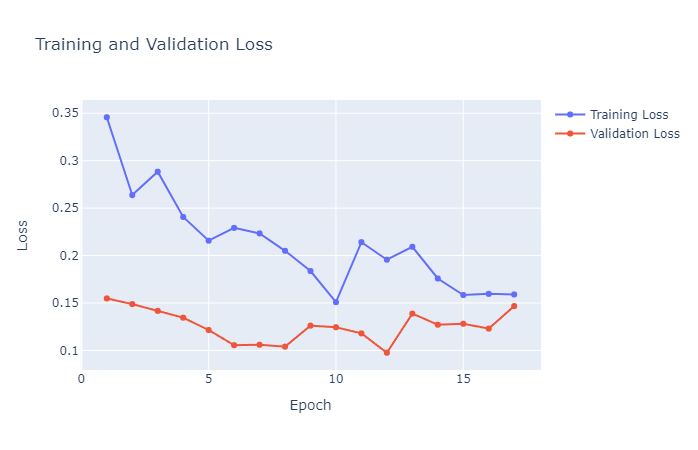

In [43]:
history_plot(epochs,history)

In [44]:
evaluate_model(model3, test_generator)

Test Loss = 0.15505819022655487
Test Accuracy = 0.9333333373069763


In [45]:
model3.save("VGG16.keras")

In [46]:
from IPython.display import FileLink
FileLink(r'VGG16.keras')

/kaggle/working/VGG16.keras

# Conclusion

In [47]:
models = [model1, model2, model3]
loss = []
accuracy = []
for model in models:
    results = model.evaluate(test_generator, verbose = 0)
    loss.append(results[0])
    accuracy.append(results[1])

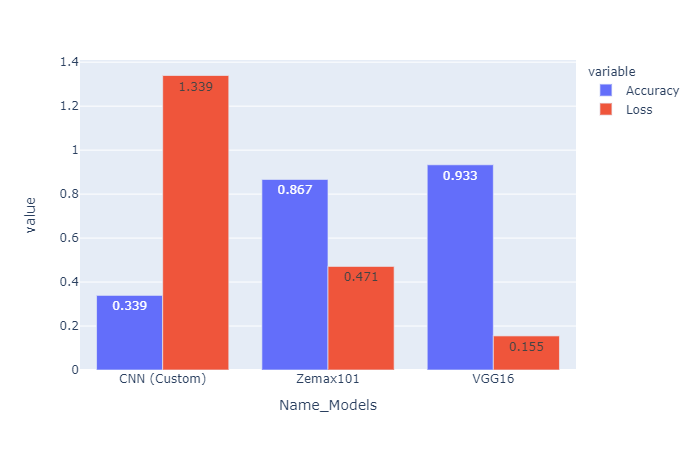

In [49]:
name_models = ["CNN (Custom)", "Zemax101", "VGG16"]
df_loss_acc = pd.DataFrame(data = {"Name_Models" : name_models,
                                  "Loss" : loss,
                                  "Accuracy" : accuracy})

fig = px.bar(data_frame = df_loss_acc, x = "Name_Models", y = ["Accuracy", "Loss"],
            barmode = "group",
            text_auto = ".3f")
fig.show()

The best model is VGG16 with higher accuracy and lowest loss